# Basic Model Testing

In [1]:
import os
import numpy as np 
import torch
from torch import nn
from torch.nn import functional as F 
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
mod1 = torch.load('/datasets/home/27/827/ausant/ECE285Project/MoDL_CenterNet/models/ctdet_coco_resdcn18.pth')

In [3]:
for name in mod1['state_dict']:
    print(name)

module.conv1.weight
module.bn1.weight
module.bn1.bias
module.bn1.running_mean
module.bn1.running_var
module.bn1.num_batches_tracked
module.layer1.0.conv1.weight
module.layer1.0.bn1.weight
module.layer1.0.bn1.bias
module.layer1.0.bn1.running_mean
module.layer1.0.bn1.running_var
module.layer1.0.bn1.num_batches_tracked
module.layer1.0.conv2.weight
module.layer1.0.bn2.weight
module.layer1.0.bn2.bias
module.layer1.0.bn2.running_mean
module.layer1.0.bn2.running_var
module.layer1.0.bn2.num_batches_tracked
module.layer1.1.conv1.weight
module.layer1.1.bn1.weight
module.layer1.1.bn1.bias
module.layer1.1.bn1.running_mean
module.layer1.1.bn1.running_var
module.layer1.1.bn1.num_batches_tracked
module.layer1.1.conv2.weight
module.layer1.1.bn2.weight
module.layer1.1.bn2.bias
module.layer1.1.bn2.running_mean
module.layer1.1.bn2.running_var
module.layer1.1.bn2.num_batches_tracked
module.layer2.0.conv1.weight
module.layer2.0.bn1.weight
module.layer2.0.bn1.bias
module.layer2.0.bn1.running_mean
module.lay

# Loading the Dataset

In [4]:
import os
import sys
sys.path.append(sys.path[0]+'/../lib') # Add library folder
#print(sys.path)

In [5]:
from opts import opts
from datasets.dataset_factory import get_dataset
from datasets.dataset.coco import COCO
from datasets.sample.ctdet import CTDetDataset
from trains.ctdet import CtdetTrainer
from trains.train_factory import train_factory

In [6]:
Dataset = get_dataset('coco', 'ctdet')

# Initializing opt

Create opt for passing to the constructor. \
Also pass a string with the training value

In [7]:
opt = type('', (), {})()
opt.data_dir = sys.path[0]+'/../../data/'
opt.task = 'ctdet'
split = 'train'

In [8]:
opt.num_workers = 4 # Number of dataloader threads (Default: 4)
opt.not_cuda_benchmark = True
opt.seed = 317
opt.batch_size = 32
opt.lr = 1.25e-4 # default=1.25e-4
opt.num_classes = Dataset.num_classes
opt.cat_spec_wh = False
opt.arch = 'res_18' # Default: dla_34
opt.head_conv = 64 # '64 for resnets and 256 for dla.'
opt.mse_loss = True
opt.dense_wh = True # apply weighted regression near center or just apply 

opt.gpus = [0];
device = 'cuda' if torch.cuda.is_available() else 'cpu'
opt.device = device

print(opt.device)

start_epoch = 0
opt.num_epochs = 1
opt.exp_id = 'exp0' # default: 'default'
opt.hide_data_time = True
opt.print_iter = 1
opt.debug = 0 # Default 0
opt.test = False
opt.keep_res = False

opt.lr_step = '90,120'
opt.lr_step = [int(i) for i in opt.lr_step.split(',')]
opt.test_scales = '1'
opt.test_scales = [float(i) for i in opt.test_scales.split(',')]

opt.not_reg_offset = False
opt.reg_offset = not opt.not_reg_offset

opt.fix_res = not opt.keep_res

opt.head_conv = -1
if opt.head_conv == -1: # init default head_conv
    opt.head_conv = 256 if 'dla' in opt.arch else 64
opt.pad = 127 if 'hourglass' in opt.arch else 31
opt.num_stacks = 2 if opt.arch == 'hourglass' else 1

opt.trainval = True
if opt.trainval:
    opt.val_intervals = 100000000

opt.master_batch_size = -1
    
if opt.debug > 0: 
    opt.num_workers = 0
    opt.batch_size = 1
    opt.gpus = [opt.gpus[0]]
    opt.master_batch_size = -1
    
if opt.master_batch_size == -1:
    opt.master_batch_size = opt.batch_size // len(opt.gpus)
    
rest_batch_size = (opt.batch_size - opt.master_batch_size)
opt.chunk_sizes = [opt.master_batch_size]
for i in range(len(opt.gpus) - 1):
    slave_chunk_size = rest_batch_size // (len(opt.gpus) - 1)
    if i < rest_batch_size % (len(opt.gpus) - 1):
        slave_chunk_size += 1
    opt.chunk_sizes.append(slave_chunk_size)

opt.root_dir = sys.path[0]+'/..'+'/../'
opt.data_dir = os.path.join(opt.root_dir, 'data')
opt.exp_dir = os.path.join(opt.root_dir, 'exp', opt.task)
opt.save_dir = os.path.join(opt.exp_dir, opt.exp_id)
opt.debug_dir = os.path.join(opt.save_dir, 'debug')

opt.resume = True
opt.load_model = ''

if opt.resume and opt.load_model == '':
  model_path = opt.save_dir[:-4] if opt.save_dir.endswith('TEST') \
              else opt.save_dir
  opt.load_model = os.path.join(model_path, 'model_last.pth')
    
opt.not_rand_crop = True
opt.shift = 0.1
opt.scale = 0.4
opt.rotate = 0
opt.flip = 0.5
opt.no_color_aug = True

opt.down_ratio = 4
opt.hm_gauss = 4 # 4 If resolution is (512,512)

input_h, input_w = Dataset.default_resolution
opt.mean, opt.std = Dataset.mean, Dataset.std
opt.num_classes = Dataset.num_classes

opt.input_res = -1
opt.input_h = -1
opt.input_w = -1

input_h = opt.input_res if opt.input_res > 0 else input_h
input_w = opt.input_res if opt.input_res > 0 else input_w
opt.input_h = opt.input_h if opt.input_h > 0 else input_h
opt.input_w = opt.input_w if opt.input_w > 0 else input_w
opt.output_h = opt.input_h // opt.down_ratio
opt.output_w = opt.input_w // opt.down_ratio
opt.input_res = max(opt.input_h, opt.input_w)
opt.output_res = max(opt.output_h, opt.output_w)

opt.heads = {'hm': opt.num_classes,
             'wh': 2 if not opt.cat_spec_wh else 2 * opt.num_classes}
if opt.reg_offset:
    opt.heads.update({'reg': 2})

opt.reg_loss = 'l1'
opt.hm_weight = 1
opt.off_weight = 1
opt.wh_weight = 0.1

opt.norm_wh = True
    
opt.eval_oracle_hm = True
opt.eval_oracle_wh = False
opt.eval_oracle_offset = False

cuda


In [9]:
dataset = Dataset(opt,split)
valset = Dataset(opt, 'val')

==> initializing coco 2017 train data.
loading annotations into memory...
Done (t=16.45s)
creating index...
index created!
Loaded train 118287 samples
==> initializing coco 2017 val data.
loading annotations into memory...
Done (t=0.63s)
creating index...
index created!
Loaded val 5000 samples


## Modifying dataset

For initial testing we are modifying the dataset to a smaller size. The following code updates the json file list to use a smalller subset of the data. 

In [10]:
all_Ids=dataset.coco.getImgIds()
print(len(all_Ids))
import skimage.io as io
img_dir='~/ECE285Project/MoDL_CenterNet/data/coco/train2017/'

118287


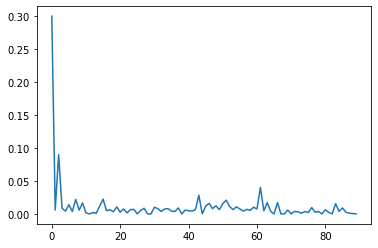

In [11]:
N=256
numsets=1
for iter in range(numsets):
    imgIds_perm=np.random.permutation(len(all_Ids))
    tmp=imgIds_perm[0:N].astype(int)
    tmp2=[all_Ids[t] for t in tmp]
    dataset.images=tmp2
    dataset.num_samples=len(dataset.images)
    sub_inst_cat=np.zeros(90)
    for j in range(N):
        sub_cat_lab=[]
        img = dataset.coco.loadImgs(dataset.images[j])[0]
        f_name=img_dir
        f_name+=img['file_name']
        annIds = dataset.coco.getAnnIds(imgIds=img['id'])
        anns = dataset.coco.loadAnns(annIds)
        sub_cat_lab=[k['category_id'] for k in anns]
        for jj in range(90):
            t=np.where(np.asarray(sub_cat_lab)==jj)
            sub_inst_cat[jj-1]+=t[0].shape[0]
    prob_sub=(sub_inst_cat+1)/np.sum(sub_inst_cat+1)    
    plt.plot(sub_inst_cat/(np.sum(sub_inst_cat)))

In [12]:
opt.num_iters = dataset.num_samples/opt.batch_size

## Dataloader

In [13]:
train_loader = td.DataLoader(
      dataset, 
      batch_size=opt.batch_size, 
      shuffle=True,
      num_workers=opt.num_workers,
      pin_memory=True,
      drop_last=True
  )

In [14]:
val_loader = torch.utils.data.DataLoader(
      valset, 
      batch_size=1, 
      shuffle=False,
      num_workers=1,
      pin_memory=True
  )

# Model

In [15]:
sys.path.append(sys.path[0]+'/../lib/models/networks/DCNv2')
from models.model import create_model, load_model, save_model
from trains.ctdet import CtdetTrainer

In [16]:
# regression on center point.
model = create_model(opt.arch, opt.heads, opt.head_conv)

=> loading pretrained model https://download.pytorch.org/models/resnet18-5c106cde.pth


In [17]:
optimizer = torch.optim.Adam(model.parameters(), opt.lr)

# Trainer

In [18]:
trainer = CtdetTrainer(opt, model, optimizer)
trainer.set_device(opt.gpus, opt.chunk_sizes, opt.device)

# Running main training loop

In [19]:
print('Starting training...')
best = 1e10
for epoch in range(start_epoch + 1, opt.num_epochs + 1):
    log_dict_train, _ = trainer.train(epoch, train_loader)
    

Starting training...


/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


4
{'loss': tensor(0.5579, device='cuda:0', grad_fn=<AddBackward0>), 'hm_loss': tensor(0., device='cuda:0'), 'wh_loss': tensor(0.2990, device='cuda:0', grad_fn=<AddBackward0>), 'off_loss': tensor(0.5280, device='cuda:0', grad_fn=<AddBackward0>)}
ctdet/exp0| train: [1][0/8.0]|Tot: 0:00:04 |ETA: 0:00:00 |loss 0.5579 |hm_loss 0.0000 |wh_loss 0.2990 |off_loss 0.5280 
4
{'loss': tensor(0.5093, device='cuda:0', grad_fn=<AddBackward0>), 'hm_loss': tensor(0., device='cuda:0'), 'wh_loss': tensor(0.2723, device='cuda:0', grad_fn=<AddBackward0>), 'off_loss': tensor(0.4820, device='cuda:0', grad_fn=<AddBackward0>)}
ctdet/exp0| train: [1][1/8.0]|Tot: 0:00:04 |ETA: 0:00:00 |loss 0.5336 |hm_loss 0.0000 |wh_loss 0.2856 |off_loss 0.5050 
4
{'loss': tensor(0.4990, device='cuda:0', grad_fn=<AddBackward0>), 'hm_loss': tensor(0., device='cuda:0'), 'wh_loss': tensor(0.3333, device='cuda:0', grad_fn=<AddBackward0>), 'off_loss': tensor(0.4657, device='cuda:0', grad_fn=<AddBackward0>)}
ctdet/exp0| train: [1][2/

In [20]:
dataset.__getitem__(0)

{'input': array([[[-1.4131755, -1.4131755, -1.4131755, ..., -1.4131755,
          -1.4131755, -1.4131755],
         [-1.4131755, -1.4131755, -1.4131755, ..., -1.4131755,
          -1.4131755, -1.4131755],
         [-1.4131755, -1.4131755, -1.4131755, ..., -1.4131755,
          -1.4131755, -1.4131755],
         ...,
         [-1.4131755, -1.4131755, -1.4131755, ..., -1.4131755,
          -1.4131755, -1.4131755],
         [-1.4131755, -1.4131755, -1.4131755, ..., -1.4131755,
          -1.4131755, -1.4131755],
         [-1.4131755, -1.4131755, -1.4131755, ..., -1.4131755,
          -1.4131755, -1.4131755]],
 
        [[-1.6316051, -1.6316051, -1.6316051, ..., -1.6316051,
          -1.6316051, -1.6316051],
         [-1.6316051, -1.6316051, -1.6316051, ..., -1.6316051,
          -1.6316051, -1.6316051],
         [-1.6316051, -1.6316051, -1.6316051, ..., -1.6316051,
          -1.6316051, -1.6316051],
         ...,
         [-1.6316051, -1.6316051, -1.6316051, ..., -1.6316051,
          -1.63

In [21]:
dataset.opt.keep_res
s = np.array([512, 512], dtype=np.float32)
print(s)

[512. 512.]


In [22]:
sf = dataset.opt.scale
cf = dataset.opt.shift
c = np.array([512 / 2., 512 / 2.], dtype=np.float32)
c[0] += s * np.clip(np.random.randn()*cf, -2*cf, 2*cf)

ValueError: setting an array element with a sequence.

In [23]:
print(log_dict_train)

{'loss': 0.4721648134291172, 'hm_loss': 0.0, 'wh_loss': 0.2910378407686949, 'off_loss': 0.4430610314011574, 'time': 0.13333333333333333}
